In [165]:
import numpy as np
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer

SEQ_LEN = 50
VOCAB_SIZE = 300
def train_tokenizer(sequences):
    tokenizer = Tokenizer(BPE())
    trainer = BpeTrainer(vocab_size=VOCAB_SIZE-1, show_progress=False)
    tokenizer.train_from_iterator(sequences, trainer)
    return tokenizer

def byte_pair_encode(sequences, tokenizer):
    tokenized = []
    for seq in sequences:
        ids = np.array(tokenizer.encode(seq).ids) + 1
        if len(ids) > SEQ_LEN:
            start = np.random.randint(0, len(ids)-SEQ_LEN)
            ids = ids[start:start+SEQ_LEN]
        padding = np.array([0]*(SEQ_LEN - len(ids)))
        tokenized.append(np.concatenate([ids, padding], axis=0))
    return np.array(tokenized, dtype="int32")

def byte_pair_decode(sequence, tokenizer):
    seq = sequence[sequence != 0] - 1
    seq = tokenizer.decode(seq).split()
    padding = ["PAD"]*(SEQ_LEN-len(seq))
    return np.concatenate([seq, padding], axis=0)

CLASSES = 2
def onehot_label(seq):
    return np.eye(CLASSES)[seq].astype("int16")

In [166]:
import os
PATH = "/Users/tgoel/Downloads/Classes/GENOME/GENOME541/hw5/encode-chip/"

paths_by_id = []
for id in np.unique([x.split(".")[0] for x in os.listdir(PATH)]):
    paths = [path for path in os.listdir(PATH) if id in path]
    paths_by_id.append((sorted(paths, key=lambda x: x.split(".")[1:], reverse=True), len(paths)))
paths_by_id = sorted(paths_by_id, key=lambda x: x[1], reverse=True)
TRAIN_PATHS, TEST_PATHS = [x[0] for x in paths_by_id[:-4]], [x[0] for x in paths_by_id[-4:]]

In [167]:
def get_data(files):

    train = len(files) == 6
    sequence_paths = [x for x in files if "fasta" in x]
    labels_paths = [x for x in files if "label" in x]

    X_valid, X_train, X_test = [open(os.path.join(PATH, path), "r").read().strip().split("\n")[1::2] for path in sequence_paths]
    t = train_tokenizer(X_train)
    X_train, X_valid, X_test = [byte_pair_encode(x, t) for x in [X_train, X_valid, X_test]]
    
    if train:
        y_valid, y_train, y_test = [onehot_label(np.array([int(x) for x in open(os.path.join(PATH, path), "r").read().strip().split("\n")])) for path in labels_paths]
    else:
        y_valid, y_train = [onehot_label(np.array([int(x) for x in open(os.path.join(PATH, path), "r").read().strip().split("\n")])) for path in labels_paths]

    return (X_train, y_train, X_valid, y_valid, X_test, y_test, t) if train else (X_train, y_train, X_valid, y_valid, X_test, t)

In [168]:
import tensorflow as tf

class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}")
        self.projection_dim = embed_dim // num_heads
        self.query_dense = tf.keras.layers.Dense(embed_dim)
        self.key_dense = tf.keras.layers.Dense(embed_dim)
        self.value_dense = tf.keras.layers.Dense(embed_dim)
        self.combine_heads = tf.keras.layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        query = self.separate_heads(query, batch_size)
        key = self.separate_heads(key, batch_size)
        value = self.separate_heads(value, batch_size)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
        output = self.combine_heads(concat_attention)
        return output

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'embed_dim': self.embed_dim,
            'num_heads': self.num_heads,
            'projection_dim': self.projection_dim,
            'query_dense': self.query_dense,
            'key_dense': self.key_dense,
            'value_dense': self.value_dense,
            'combine_heads': self.combine_heads,
        })
        return config

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = tf.keras.Sequential([tf.keras.layers.Dense(ff_dim, activation=tf.keras.activations.swish), tf.keras.layers.Dense(embed_dim),])
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'att': self.att,
            'ffn': self.ffn,
            'layernorm1': self.layernorm1,
            'layernorm2': self.layernorm2,
            'dropout1': self.dropout1,
            'dropout2': self.dropout2,
        })
        return config

class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'token_emb': self.token_emb,
            'pos_emb': self.pos_emb,
        })
        return config

def transformer_model(embed_dim=16, n_heads=4):
    tf.keras.backend.clear_session()
    inp = tf.keras.layers.Input(shape=(SEQ_LEN,))
    x = TokenAndPositionEmbedding(SEQ_LEN, VOCAB_SIZE, embed_dim)(inp)
    x = TransformerBlock(embed_dim, n_heads, 256)(x)
    x = TransformerBlock(embed_dim, n_heads, 512)(x)
    x = TransformerBlock(embed_dim, n_heads, 256)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation=tf.keras.activations.swish)(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(128, activation=tf.keras.activations.swish)(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(32, activation=tf.keras.activations.swish)(x)
    out = tf.keras.layers.Dense(CLASSES, activation="softmax")(x)
    model = tf.keras.Model(inputs=inp, outputs=out)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC'])
    return model

In [ ]:
for transcription_factor in range(len(TRAIN_PATHS)):
    print("\nTraining Model for TF", str(transcription_factor+1))
    model = transformer_model()
    checkpoint = tf.keras.callbacks.ModelCheckpoint("/Users/tgoel/Downloads/Classes/GENOME/GENOME541/hw5/models/model_" + str(transcription_factor+1) + ".yaml", monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)
    X_train, y_train, X_valid, y_valid, X_test, y_test, tknzr = get_data(TRAIN_PATHS[transcription_factor])

    model.fit(X_train, y_train, epochs=10, batch_size=32, shuffle=True,
              validation_data=[X_valid, y_valid], callbacks=[checkpoint])

    model.load_weights("/Users/tgoel/Downloads/Classes/GENOME/GENOME541/hw5/models/model_" + str(transcription_factor+1) + ".yaml")
    model.evaluate(X_test, y_test)

In [ ]:
y_preds = []
for transcription_factor in range(len(TRAIN_PATHS), len(TRAIN_PATHS) + len(TEST_PATHS)):
    print("\nTraining Model for TF", str(transcription_factor+1))
    model = transformer_model()
    checkpoint = tf.keras.callbacks.ModelCheckpoint("/Users/tgoel/Downloads/Classes/GENOME/GENOME541/hw5/models/model_" + str(transcription_factor+1) + ".yaml", monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)
    X_train, y_train, X_valid, y_valid, X_test, tknzr = get_data(TEST_PATHS[transcription_factor-len(TRAIN_PATHS)])

    model.fit(X_train, y_train, epochs=10, batch_size=32, shuffle=True,
              validation_data=[X_valid, y_valid], callbacks=[checkpoint])
    
    model.load_weights("/Users/tgoel/Downloads/Classes/GENOME/GENOME541/hw5/models/model_" + str(transcription_factor+1) + ".yaml")
    y_preds.append(model.predict(X_test)[::,1])

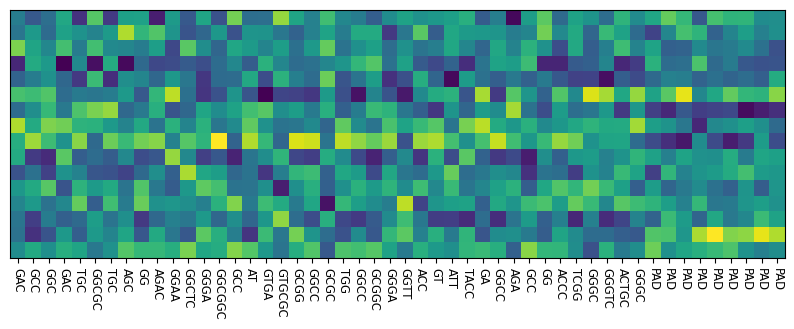

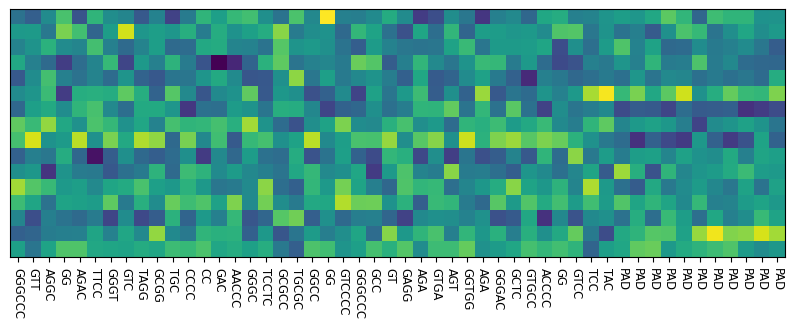

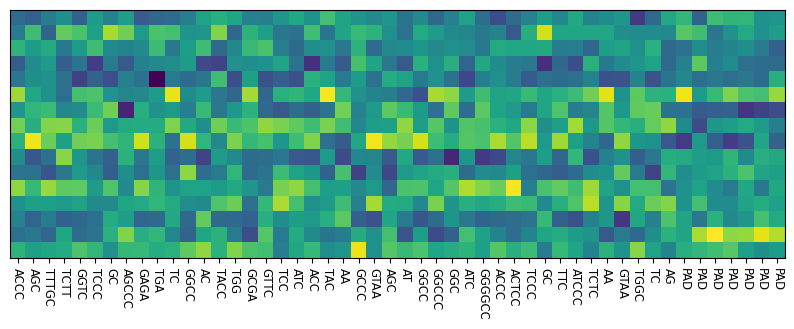

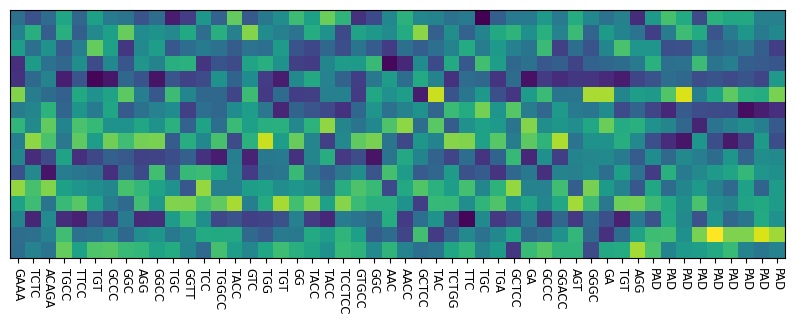

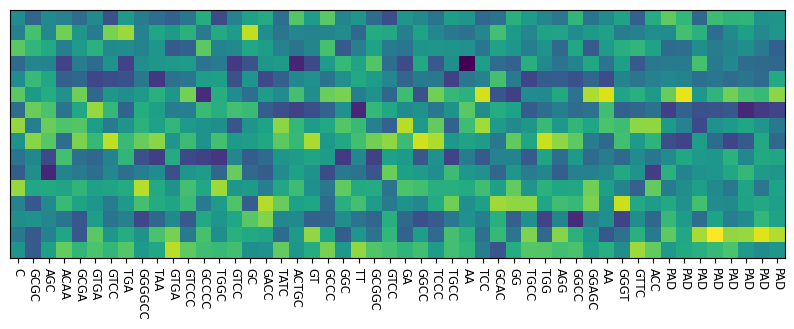

In [141]:
import matplotlib.pyplot as plt

def activation_maps(n_visuals, sequences, model, tokenizer, layer):
    m = tf.keras.models.Model(inputs=model.layers[0].output, outputs=model.layers[layer-1].output)
    for i in np.random.randint(0, len(sequences), n_visuals):
        plt.figure(figsize=(10, 5))
        plt.yticks([])
        plt.xticks(list(range(SEQ_LEN)), byte_pair_decode(sequences[i], tokenizer), size='small')
        plt.xticks(rotation=270)
        plt.imshow(m(sequences[i:i+1])[0].numpy().T, cmap='viridis')

activation_maps(5, X_test, model, tknzr, 3)

In [ ]:
import pickle as pkl

for transcription_factor, y_pred in enumerate(y_preds):
    with open("/Users/tgoel/Downloads/Classes/GENOME/GENOME541/hw5/predictions_" + str(transcription_factor+1) + ".pkl", "wb") as f:
        pkl.dump(y_pred, f)